In [1]:
import os
import random
import torch
import torch.nn as nn
from torch.nn.functional import mse_loss, l1_loss
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, clear_output
from time import time
from PIL import Image
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def show_tensor(tensor, transpose=True, normalize='auto', figsize=(8,8), **kwargs):
    if not isinstance(tensor, torch.Tensor):
        tensor = torch.tensor(tensor)
    tensor = tensor.detach().cpu()
    if tensor.ndim == 3:
        tensor = tensor.unsqueeze(0)
    if normalize=='auto':
        if tensor.max() <= 1.0 and tensor.min() >= 0.0:
            normalize = False
        else:
            normalize = True
            print('tensor has been normalized')
    grid = torchvision.utils.make_grid(tensor, normalize=normalize, **kwargs)
    if transpose:
        grid = grid.permute(1,2,0)
    plt.figure(figsize=figsize)
    return plt.imshow(grid)

In [3]:
class ABDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.root = root
        self.transform = transform
        
        if train:
            pathA = Path(os.path.join(root, 'trainA'))
            pathB = Path(os.path.join(root, 'trainB'))
        else:
            pathA = Path(os.path.join(root, 'testA'))
            pathB = Path(os.path.join(root, 'testB'))
        
        self.imagesA = list(pathA.rglob('*.*'))
        self.imagesB = list(pathB.rglob('*.*'))
        
    def __len__(self):
        return min(len(self.imagesA), len(self.imagesB))
    
    def lenA(self):
        return len(self.imagesA)
    
    def lenB(self):
        return len(self.imagesB)
    
    def __getitem__(self, idxes):
        a = Image.open(self.imagesA[idxes[0]])
        b = Image.open(self.imagesB[idxes[1]])
        if a.mode != 'RGB':
            a = a.convert('RGB')
        if b.mode != 'RGB':
            b = b.convert('RGB')
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)
        return a, b

class ABRandomSampler(Sampler):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __iter__(self):
        idxsA = np.random.permutation(self.data.lenA())
        idxsB = np.random.permutation(self.data.lenB())
        for iA, iB in zip(idxsA, idxsB):
            yield iA, iB

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
class residual_block(nn.Module):
    def __init__(self, in_features, out_features, kernel=3, padding=1, padding_mode='reflect', **kwargs):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel, padding=padding, padding_mode=padding_mode, **kwargs),
            nn.InstanceNorm2d(out_features, affine=False),
            nn.ReLU(),
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel, padding=padding, padding_mode=padding_mode, **kwargs),
            nn.InstanceNorm2d(out_features, affine=False),
        )
        self.identity = nn.Identity()
        
    def forward(self, x):
        identity = x 
        x = self.conv_1(x)
        out = self.conv_2(x)
        return out + identity

    
def conv_block(in_features, out_features, kernel=3, stride=1, padding=0, padding_mode='reflect', **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel, stride=stride, padding=padding, padding_mode=padding_mode, **kwargs),
        nn.InstanceNorm2d(out_features, affine=False),
        nn.ReLU()
    )

def upconv_block(in_features, out_features, kernel=3, stride=1, padding=0, output_padding=0, **kwargs):
    return nn.Sequential(
        nn.ConvTranspose2d(in_features, out_features, kernel, stride=stride, padding=padding, output_padding=output_padding, **kwargs),
        nn.InstanceNorm2d(out_features, affine=False),
        nn.ReLU()
    )


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            conv_block(3, 32, kernel=7, padding=3),
            conv_block(32, 64, kernel=3, stride=2, padding=1),
            conv_block(64, 128, kernel=3, stride=2, padding=1),
            residual_block(128, 128, kernel=3),
            residual_block(128, 128, kernel=3),
            residual_block(128, 128, kernel=3),
            residual_block(128, 128, kernel=3),
            residual_block(128, 128, kernel=3),
            upconv_block(128, 64, kernel=3, stride=2, padding=1, output_padding=1),
            upconv_block(64, 32, kernel=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(32, 3, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.layers(x)
        return x

    
class Discriminator(nn.Module):
    # C64(no-norm)-C128-C256-C512-C1_out
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.InstanceNorm2d(64, affine=False),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128, affine=False),
            nn.LeakyReLU(0.2, True),
            
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256, affine=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 1, 1),
            nn.AdaptiveAvgPool2d(1),
            
            nn.Flatten(0),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [7]:
def generate(G, F, real_x, real_y):
    fake_y = G(real_x)  # x -> fake_y
    rec_x = F(fake_y)   # x -> fake_y -> rec_x
    fake_x = F(real_y)  # y -> fake_x
    rec_y = G(fake_x)   # y -> fake_x -> rec_y
    return fake_y, rec_x, fake_x, rec_y

In [8]:
# # horse2zebra

# batch_size = 12

# image_size = 128
# transform = transforms.Compose([
#     transforms.Resize(image_size),
#     transforms.CenterCrop(image_size),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

# dataset = ABDataset('data/horse2zebra', transform=transform)
# loader = DataLoader(dataset, batch_size=batch_size, sampler=ABRandomSampler(dataset), num_workers=0)

In [25]:
# car vinylize

batch_size = 12

image_size = (192, 256)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ABDataset('../input/car-styling/cars/', transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, sampler=ABRandomSampler(dataset), num_workers=0)

tensor has been normalized
tensor has been normalized


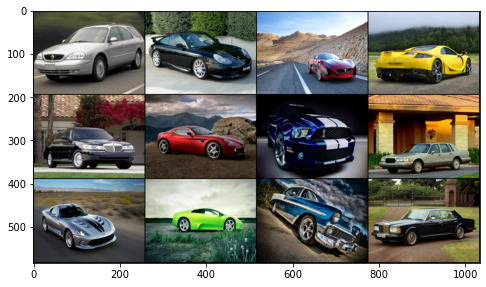

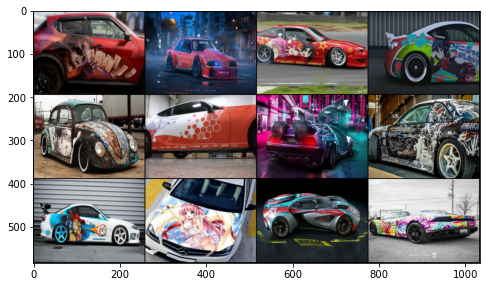

In [26]:
for i in loader:
    break
show_tensor(i[0], nrow=4)
show_tensor(i[1], nrow=4)

In [11]:
Dx = Discriminator().to(device)
Dy = Discriminator().to(device)

Dx.apply(weights_init)
Dy.apply(weights_init);

In [12]:
G = Generator().to(device)
F = Generator().to(device)

G.apply(weights_init)
F.apply(weights_init);

In [13]:
from itertools import chain

optimizer_G = torch.optim.Adam(chain(G.parameters(), F.parameters()), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(chain(Dx.parameters(), Dy.parameters()), lr=2e-4, betas=(0.5, 0.999))

In [27]:
class LinearLR:
    def __init__(self, optimizers, total_steps, end_lr=0.0):
        # only for 1 param_group
        self.optimizers = optimizers
        self.total_steps = total_steps
        self.end_lr = end_lr
        self.start_lr = optimizers[0].param_groups[0]['lr']
        self.cur_step = 0
    
    def step(self):
        self.cur_step += 1
        for opt in self.optimizers:
            opt.param_groups[0]['lr'] = self.start_lr + ((self.end_lr - self.start_lr)*self.cur_step/self.total_steps)

In [16]:
loads = torch.load('../input/cyclegan-cars-100e/cycleGAN_cars_100e.pth')

[x.load_state_dict(l) for x, l in zip([G,F,Dx,Dy], loads.values())]

[<All keys matched successfully>,
 <All keys matched successfully>,
 <All keys matched successfully>,
 <All keys matched successfully>]

In [ ]:
num_epochs = 100
lambda_gan = 1.0
lambda_cycle = 10.0
lambda_identity = 1.0
img_list = []
losses = []
scheduler = None

start_time = time()

i = 0
for epoch in range(num_epochs):
    for real_x, real_y in loader:
        real_x, real_y = real_x.to(device), real_y.to(device)
        b = real_x.shape[0]
        label_zeros = torch.zeros(b).to(device)
        label_ones = torch.ones(b).to(device)
        
        G.requires_grad_(True)
        F.requires_grad_(True)
        Dx.requires_grad_(False)
        Dy.requires_grad_(False)
        optimizer_G.zero_grad()
        fake_y, rec_x, fake_x, rec_y = generate(G, F, real_x, real_y)
        loss_G = mse_loss(Dy(fake_y), label_ones)
        loss_F = mse_loss(Dx(fake_x), label_ones)
        loss_cyc_G = l1_loss(rec_x, real_x)
        loss_cyc_F = l1_loss(rec_y, real_y)
    #     loss_identity_G = l1_loss(G(real_y), real_y)
    #     loss_identity_F = l1_loss(F(real_x), real_x)
        loss = lambda_gan*(loss_G + loss_F) + lambda_cycle*(loss_cyc_G + loss_cyc_F)
    #     + lambda_identity*(loss_identity_G + loss_identity_F)
        loss.backward()
        optimizer_G.step()

        G.requires_grad_(False)
        F.requires_grad_(False)
        Dx.requires_grad_(True)
        Dy.requires_grad_(True)
        optimizer_D.zero_grad()
        # loss Dy, backward Dy
        loss_Dy = 0.5 * (mse_loss(Dy(real_y), label_ones) + mse_loss(Dy(fake_y.detach()), label_zeros))
        loss_Dy.backward()
        # loss Dx, backward Dx
        loss_Dx = 0.5 * (mse_loss(Dx(real_x), label_ones) + mse_loss(Dx(fake_x.detach()), label_zeros))
        loss_Dx.backward()
        optimizer_D.step()

        losses.append([x.item() for x in [loss_G, loss_F, loss_cyc_G, loss_cyc_F, loss, loss_Dy, loss_Dx]])
        
        if scheduler: scheduler.step()

        if i % 20 == 0:
            clear_output(True)
            m = int(time() - start_time)//60
            s = int(time() - start_time)%60
            print(f'{epoch}-{i}, {loss:.4f} {loss_Dy:.4f} {loss_Dx:.4f} ({m:>02}:{s:>02})')
            img_list.append([fake_y[[0]], rec_x[[0]], fake_x[[0]], rec_y[[0]]])
            show_tensor(torch.cat(img_list[-1], 0), nrow=2)
            plt.show()
            losses_pd = pd.DataFrame(losses, columns=['loss_G', 'loss_F', 'loss_cyc_G', 'loss_cyc_F', 'loss_sum', 'loss_Dy', 'loss_Dx'])
            losses_pd.iloc[:, :5].plot()
            plt.show()
            losses_pd.iloc[:, 5:].plot()
            plt.show()
            torch.save({'G':G.state_dict(), 'F':F.state_dict(), 'Dx':Dx.state_dict(), 'Dy':Dy.state_dict()}, 'cycleGAN_cars_training.pth')
        i += 1

99-7380, 2.1332 0.1037 0.0819 (134:15)
tensor has been normalized


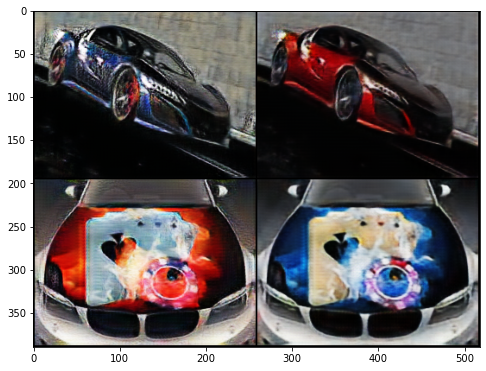

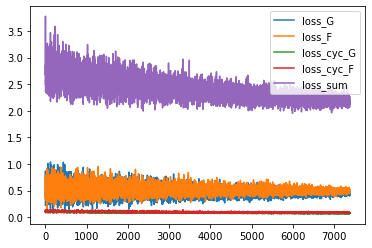

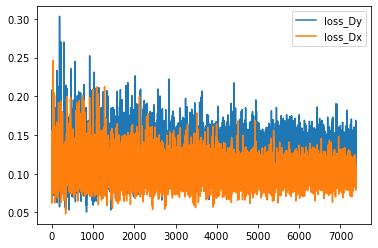

In [28]:
num_epochs = 100
lambda_gan = 1.0
lambda_cycle = 8.0
lambda_identity = 1.0
img_list = []
losses = []
scheduler = LinearLR([optimizer_G, optimizer_D], len(loader)*num_epochs, end_lr=0.0)

start_time = time()

i = 0
for epoch in range(num_epochs):
    for real_x, real_y in loader:
        real_x, real_y = real_x.to(device), real_y.to(device)
        b = real_x.shape[0]
        label_zeros = torch.zeros(b).to(device)
        label_ones = torch.ones(b).to(device)
        
        G.requires_grad_(True)
        F.requires_grad_(True)
        Dx.requires_grad_(False)
        Dy.requires_grad_(False)
        optimizer_G.zero_grad()
        fake_y, rec_x, fake_x, rec_y = generate(G, F, real_x, real_y)
        loss_G = mse_loss(Dy(fake_y), label_ones)
        loss_F = mse_loss(Dx(fake_x), label_ones)
        loss_cyc_G = l1_loss(rec_x, real_x)
        loss_cyc_F = l1_loss(rec_y, real_y)
    #     loss_identity_G = l1_loss(G(real_y), real_y)
    #     loss_identity_F = l1_loss(F(real_x), real_x)
        loss = lambda_gan*(loss_G + loss_F) + lambda_cycle*(loss_cyc_G + loss_cyc_F)
    #     + lambda_identity*(loss_identity_G + loss_identity_F)
        loss.backward()
        optimizer_G.step()

        G.requires_grad_(False)
        F.requires_grad_(False)
        Dx.requires_grad_(True)
        Dy.requires_grad_(True)
        optimizer_D.zero_grad()
        # loss Dy, backward Dy
        loss_Dy = 0.5 * (mse_loss(Dy(real_y), label_ones) + mse_loss(Dy(fake_y.detach()), label_zeros))
        loss_Dy.backward()
        # loss Dx, backward Dx
        loss_Dx = 0.5 * (mse_loss(Dx(real_x), label_ones) + mse_loss(Dx(fake_x.detach()), label_zeros))
        loss_Dx.backward()
        optimizer_D.step()

        losses.append([x.item() for x in [loss_G, loss_F, loss_cyc_G, loss_cyc_F, loss, loss_Dy, loss_Dx]])
        
        if scheduler: scheduler.step()

        if i % 20 == 0:
            clear_output(True)
            m = int(time() - start_time)//60
            s = int(time() - start_time)%60
            print(f'{epoch}-{i}, {loss:.4f} {loss_Dy:.4f} {loss_Dx:.4f} ({m:>02}:{s:>02})')
            img_list.append([fake_y[[0]], rec_x[[0]], fake_x[[0]], rec_y[[0]]])
            show_tensor(torch.cat(img_list[-1], 0), nrow=2)
            plt.show()
            losses_pd = pd.DataFrame(losses, columns=['loss_G', 'loss_F', 'loss_cyc_G', 'loss_cyc_F', 'loss_sum', 'loss_Dy', 'loss_Dx'])
            losses_pd.iloc[:, :5].plot()
            plt.show()
            losses_pd.iloc[:, 5:].plot()
            plt.show()
            torch.save({'G':G.state_dict(), 'F':F.state_dict(), 'Dx':Dx.state_dict(), 'Dy':Dy.state_dict()}, 'cycleGAN_cars_training.pth')
        i += 1

In [29]:
torch.save({'G':G.state_dict(), 'F':F.state_dict(), 'Dx':Dx.state_dict(), 'Dy':Dy.state_dict()}, 'cycleGAN_cars_training.pth')

In [ ]:
test_dataset = ABDataset('data/horse2zebra', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=ABRandomSampler(test_dataset), num_workers=0)

tensor has been normalized


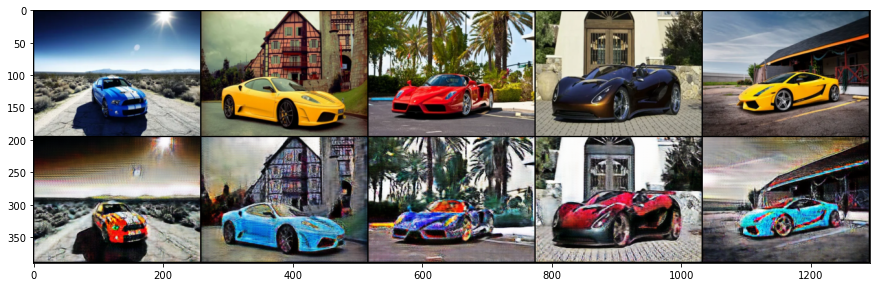

In [47]:
x, y = [i[:5].to(device) for i in next(iter(loader))]
G.eval()
with torch.no_grad():
    fake_y = G(x)
t = torch.cat([x, fake_y], dim=0)
show_tensor(t, nrow=5, figsize=(20,15))